In [8]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  
sys.path.append(project_root)

In [2]:
from utils.ocr_dataset import LicensePlateDataset

In [3]:
from utils.ocr_dataset import LicensePlateDataset
from torchvision import transforms

# Paths
images_folder = "C:/Users/Badis/Desktop/vehicle-monitoring-system/datasets/license_plate_recognition/train"
detection_csv = "C:/Users/Badis/Desktop/vehicle-monitoring-system/datasets/license_plate_recognition/license_plates_detection_train.csv"
recognition_csv = "C:/Users/Badis/Desktop/vehicle-monitoring-system/datasets/license_plate_recognition/license_plates_recognition_train.csv"

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Resize((128, 128))  # Resize to 128x128
])

# Initialize Dataset
dataset = LicensePlateDataset(
    images_folder=images_folder,
    detection_csv=detection_csv,
    recognition_csv=recognition_csv,
    transform=transform
)

# Check Dataset
sample_img, sample_label = dataset[0]
print("Image size:", sample_img.size())  # Should show torch.Size([3, 128, 128])
print("Label indices:", sample_label)
print("Label text:", "".join([dataset.idx_to_char[idx.item()] for idx in sample_label]))


Image size: torch.Size([3, 128, 128])
Label indices: tensor([27, 28, 34, 19, 34, 26, 34, 32])
Label text: 128T8086


In [9]:
from torch.nn.utils.rnn import pad_sequence
import torch  # Ensure this import is present


def collate_fn(batch):
    """Custom collate function to handle variable-length labels."""
    images, labels = zip(*batch)  # Unpack the batch
    images = torch.stack(images)  # Stack images (all are of the same size)
    labels = [label.clone().detach() for label in labels]  # Clone and detach tensors
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)  # Pad labels to the same length
    return images, labels_padded



In [10]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Check DataLoader
images, labels = next(iter(train_loader))
print("Batch size (images):", images.size())  # Expected: torch.Size([batch_size, 3, height, width])
print("Batch size (labels):", labels.size())  # Expected: torch.Size([batch_size, max_label_length])


Batch size (images): torch.Size([32, 3, 128, 128])
Batch size (labels): torch.Size([32, 8])


In [12]:
import sys
import os
sys.path.append(os.path.abspath("scripts"))


In [14]:
import torch
import torch.nn as nn  # Importing nn module

from scripts.ocr_model import LicensePlateOCR

# Define model parameters
num_classes = len(dataset.chars)  # Number of characters in the dataset
model = LicensePlateOCR(num_classes=num_classes)

# Define training components
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model initialized and moved to device.")


Model initialized and moved to device.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# Training function
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)  # Shape: [batch_size, max_seq_len, num_classes]

            # Align labels with max_seq_len
            batch_size, max_seq_len, num_classes = outputs.shape
            padded_labels = torch.zeros((batch_size, max_seq_len), dtype=torch.long).to(device)

            for i, label in enumerate(labels):
                seq_len = min(len(label), max_seq_len)  # Limit to max_seq_len
                padded_labels[i, :seq_len] = label[:seq_len]  # Truncate or pad

            # Flatten for loss calculation
            outputs_flat = outputs.view(batch_size * max_seq_len, num_classes)
            labels_flat = padded_labels.contiguous().view(-1)

            # Debug shapes
            print(f"Epoch {epoch+1}, Batch size: {batch_size}")
            print("Outputs_flat shape:", outputs_flat.shape)
            print("Labels_flat shape:", labels_flat.shape)

            # Calculate loss
            loss = criterion(outputs_flat, labels_flat)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Step the scheduler
        scheduler.step()

        # Log training progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    print("Training completed.")

# Train the model
num_epochs = 10
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs)


Epoch 1, Batch size: 32
Outputs_flat shape: torch.Size([1024, 37])
Labels_flat shape: torch.Size([1024])
Epoch 1, Batch size: 32
Outputs_flat shape: torch.Size([1024, 37])
Labels_flat shape: torch.Size([1024])
Epoch 1, Batch size: 32
Outputs_flat shape: torch.Size([1024, 37])
Labels_flat shape: torch.Size([1024])
Epoch 1, Batch size: 32
Outputs_flat shape: torch.Size([1024, 37])
Labels_flat shape: torch.Size([1024])
Epoch 1, Batch size: 32
Outputs_flat shape: torch.Size([1024, 37])
Labels_flat shape: torch.Size([1024])
Epoch 1, Batch size: 32
Outputs_flat shape: torch.Size([1024, 37])
Labels_flat shape: torch.Size([1024])
Epoch 1, Batch size: 32
Outputs_flat shape: torch.Size([1024, 37])
Labels_flat shape: torch.Size([1024])
Epoch 1, Batch size: 32
Outputs_flat shape: torch.Size([1024, 37])
Labels_flat shape: torch.Size([1024])
Epoch 1, Batch size: 32
Outputs_flat shape: torch.Size([1024, 37])
Labels_flat shape: torch.Size([1024])
Epoch 1, Batch size: 32
Outputs_flat shape: torch.Size(

In [25]:
model_save_path = "C:/Users/Badis/Desktop/vehicle-monitoring-system/models/license_plate_ocr.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to C:/Users/Badis/Desktop/vehicle-monitoring-system/models/license_plate_ocr.pth


In [26]:
model_load_path = "C:/Users/Badis/Desktop/vehicle-monitoring-system/models/license_plate_ocr.pth"
loaded_model = LicensePlateOCR(num_classes=len(dataset.chars))
loaded_model.load_state_dict(torch.load(model_load_path))

loaded_model.to(device)
print(f"Model loaded from {model_load_path}")


Model loaded from C:/Users/Badis/Desktop/vehicle-monitoring-system/models/license_plate_ocr.pth


C:\Users\Badis\AppData\Local\Temp\ipykernel_30840\186877561.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_load_path))


In [27]:
import os
from PIL import Image, ImageDraw
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from scripts.ocr_model import LicensePlateOCR

def detect_plate_region(image):
    width, height = image.size
    xmin, ymin = int(width * 0.3), int(height * 0.7)
    xmax, ymax = int(width * 0.7), int(height * 0.85)
    return xmin, ymin, xmax, ymax

def test_model_on_vehicle_images(model, images_folder, transform, device):
    model.eval() 

    for img_name in os.listdir(images_folder):
        img_path = os.path.join(images_folder, img_name)
        img = Image.open(img_path).convert("RGB")
    
        xmin, ymin, xmax, ymax = detect_plate_region(img)
        plate_img = img.crop((xmin, ymin, xmax, ymax))

        if transform:
            plate_img = transform(plate_img)
        plate_img = plate_img.unsqueeze(0).to(device)  

        with torch.no_grad():
            outputs = model(plate_img)
            _, preds = torch.max(outputs, dim=2)  
            pred_text = "".join(
                [dataset.idx_to_char[idx.item()] for idx in preds[0] if idx.item() != 0]
            )

        print(f"Image: {img_name}")
        print(f"Predicted Plate Text: {pred_text}")
        draw = ImageDraw.Draw(img)
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
        img.show()

model_load_path = "C:/Users/Badis/Desktop/vehicle-monitoring-system/models/license_plate_ocr.pth"
loaded_model = LicensePlateOCR(num_classes=len(dataset.chars))
loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.to(device)
test_images_folder = "C:/Users/Badis/Desktop/vehicle-monitoring-system/datasets/license_plate_recognition/test"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
test_model_on_vehicle_images(loaded_model, test_images_folder, transform, device)


C:\Users\Badis\AppData\Local\Temp\ipykernel_30840\750699021.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_load_path))


Image: 1000.jpg
Predicted Plate Text: 11TTTTTTTT99999999
Image: 1001.jpg
Predicted Plate Text: 11TTTTTTTT99999999999999999999
Image: 1002.jpg
Predicted Plate Text: 11TTTTTTTT99999999999999999999
Image: 1003.jpg
Predicted Plate Text: 11TTT999
Image: 1004.jpg
Predicted Plate Text: 11TTTTT9999
Image: 1005.jpg
Predicted Plate Text: 11TTTTTTT999
Image: 1006.jpg
Predicted Plate Text: 11TTT999
Image: 1007.jpg
Predicted Plate Text: 11TTTT99999999
Image: 1008.jpg
Predicted Plate Text: 11TTTTTTTTT999999
Image: 1009.jpg
Predicted Plate Text: 11TTTTT999999
Image: 1010.jpg
Predicted Plate Text: 11TTTTTTTTTTTT999999999999999999
Image: 1011.jpg
Predicted Plate Text: 11TTTTTTTTTTT999999999999999
Image: 1012.jpg
Predicted Plate Text: 11TTTT999
Image: 1013.jpg
Predicted Plate Text: 11TTTTTTTTTTTTT99999999999999999
Image: 1014.jpg
Predicted Plate Text: 11TTTTTTTTTTT999999999
Image: 1015.jpg
Predicted Plate Text: 11TTTT9999
Image: 1016.jpg
Predicted Plate Text: 11TTTTT999
Image: 1017.jpg
Predicted Plate T

In [1]:
def detect_plate_region(image):
    width, height = image.size
    xmin = int(width * 0.2)  
    ymin = int(height * 0.6)  
    xmax = int(width * 0.8)  
    ymax = int(height * 0.85)  
    draw = ImageDraw.Draw(image.copy())
    draw.rectangle([xmin, ymin, xmax, ymax], outline="blue", width=3)
    image.show()

    return xmin, ymin, xmax, ymax


In [2]:
from ultralytics import YOLO

def detect_plate_with_yolo(image_path, model_path="yolov5s.pt"):
    yolo_model = YOLO(model_path)
    results = yolo_model(image_path)
    for result in results:
        for box in result.boxes.xyxy:  
            return tuple(map(int, box))

    return None

bbox = detect_plate_with_yolo("C:/Users/Badis/Desktop/vehicle-monitoring-system/datasets/license_plate_recognition/test/912.jpg")
if bbox:
    xmin, ymin, xmax, ymax = bbox


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Badis\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:18<00:00, 1.02MB/s]



image 1/1 C:\Users\Badis\Desktop\vehicle-monitoring-system\datasets\license_plate_recognition\test\912.jpg: 384x640 2 persons, 1 car, 1 handbag, 115.4ms
Speed: 1.1ms preprocess, 115.4ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)


PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


image 1/1 C:\Users\Badis\Desktop\vehicle-monitoring-system\datasets\license_plate_recognition\test\912.jpg: 384x640 2 persons, 1 car, 1 handbag, 107.5ms
Speed: 2.0ms preprocess, 107.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


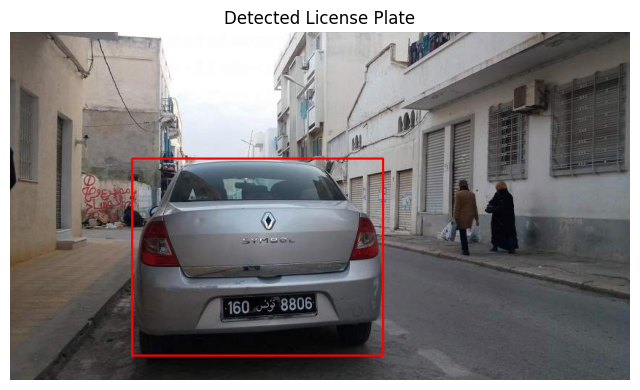

In [3]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

def detect_plate_with_yolo(image_path, model_path="yolov5s.pt"):
    yolo_model = YOLO(model_path)
    results = yolo_model(image_path)
    for result in results:
        for box in result.boxes.xyxy:  
            return tuple(map(int, box))  # Return bounding box as integers (xmin, ymin, xmax, ymax)

    return None

image_path = "C:/Users/Badis/Desktop/vehicle-monitoring-system/datasets/license_plate_recognition/test/912.jpg"

bbox = detect_plate_with_yolo(image_path)
if bbox:
    xmin, ymin, xmax, ymax = bbox
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Detected License Plate")
    plt.show()
else:
    print("No license plate detected.")


In [10]:
import sys
import os

# Add the project root directory to the Python path
sys.path.append(os.path.abspath("C:/Users/Badis/Desktop/vehicle-monitoring-system"))


In [ ]:
from PIL import Image, ImageDraw
import torch
from torchvision import transforms
from ultralytics import YOLO
from scripts.ocr_model import LicensePlateOCR

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load OCR model
model_load_path = "C:/Users/Badis/Desktop/vehicle-monitoring-system/models/license_plate_ocr.pth"
ocr_model = LicensePlateOCR(num_classes=37)  # Adjust num_classes to match your OCR model
ocr_model.load_state_dict(torch.load(model_load_path))
ocr_model.to(device)
ocr_model.eval()

# YOLO model for license plate detection
yolo_model = YOLO("yolov5s.pt")  # Replace with the path to your YOLO model if needed

# Define preprocessing for OCR
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Function to test on a single image
def test_single_image(image_path):
    # Open image
    img = Image.open(image_path).convert("RGB")
    
    # Detect plate with YOLO
    results = yolo_model(image_path)
    bbox = None
    for result in results:
        for box in result.boxes.xyxy:  # Get bounding box coordinates
            bbox = tuple(map(int, box))  # Convert to integers
            break
    if not bbox:
        print("No license plate detected.")
        return
    
    # Extract the bounding box
    xmin, ymin, xmax, ymax = bbox
    cropped_plate = img.crop((xmin, ymin, xmax, ymax))  # Crop the detected plate region
    
    # Preprocess for OCR
    processed_plate = transform(cropped_plate).unsqueeze(0).to(device)
    
    # Predict the license plate text
    with torch.no_grad():
        outputs = ocr_model(processed_plate)
        _, preds = torch.max(outputs, dim=2)
        pred_text = "".join(
            [ocr_model.idx_to_char[idx.item()] for idx in preds[0] if idx.item() != 0]
        )
    
    print(f"Predicted License Plate Text: {pred_text}")
    
    # Draw bounding box on the original image
    draw = ImageDraw.Draw(img)
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
    img.show()

# Test with a single image
image_path = "C:/Users/Badis/Desktop/vehicle-monitoring-system/datasets/license_plate_recognition/test/912.jpg"
test_single_image(image_path)


ModuleNotFoundError: No module named 'scripts.ocr_model'

: 

In [18]:
from .ocr_model import LicensePlateOCR
from .resnet_model import get_resnet18


ImportError: attempted relative import with no known parent package